# Setup

### Importing Libraries

In [1]:
import numpy as np

from scipy import sparse
from scipy.sparse.linalg import spsolve
import itertools

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import HTML

import seaborn as sb

/Users/rayan/.pyenv/versions/3.7.7/envs/Physics113/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Setting initial parameters

In [11]:
#number of time steps
T=400
#size of time step
dt = 0.2

#size of cell in x and y
xmax=25
ymax=25

#size of spatial steps
dx = 0.5
dy = dx

N = 200
#total number of spatial steps
steps = int(N/dx)

#spread of the initial gaussian in x and y
sx = 1
sy = 4

#initial position of the Gaussian
x0 = xmax/4
y0 = ymax/2

#x wavenumber of wavepacket
k0 = 10

#constants for the matrices, from TDSE
alpha = 1j*dt/(2*dx**2)
beta = 1j*dt

#initialising the x,y grid
x = np.linspace(0,xmax,steps)
y = np.linspace(0,ymax,steps)
xx,yy = np.meshgrid(x,y)

#setting the potential value
Vmax = 20
#initializing the potential matrix
V = np.zeros((steps,steps))

#setting slit parameters

#x position of slit
slit_x = int(steps/2)

#slit extent in x
eps=8

#bottom and top positions of each slit
s1_b = 110
s1_t = 130

s2_b = 150
s2_t = 170

s3_b = 190
s3_t = 210

s4_b = 230
s4_t = 250

s5_b = 270
s5_t = 290

#setting the heatmap to display NANs as grey
cmap = plt.get_cmap("magma")
cmap.set_bad(color='grey', alpha=1)

#setting the potential to be Vmax on the slit-wall, except at slit positions, at slit_x +/- eps
V[0:s1_b,slit_x-eps:slit_x+eps]=Vmax
V[s1_t:s2_b,slit_x-eps:slit_x+eps]=Vmax
V[s2_t:s3_b,slit_x-eps:slit_x+eps]=Vmax
V[s3_t:s4_b,slit_x-eps:slit_x+eps]=Vmax
V[s4_t:s5_b,slit_x-eps:slit_x+eps]=Vmax
V[s5_t:-1,slit_x-eps:slit_x+eps]=Vmax


#producing the initial wavepacket
def gaussian(x,y,x0,y0,sx,sy,k0):
    return np.exp(-((x-x0)**2)/(2*(sx**2)))*np.exp(-((y-y0)**2)/(2*(sy**2)))*np.exp(1j*k0*x)
initial_wavefunc = gaussian(xx,yy,x0,y0,sx,sy,k0)

#setting the wavefunction to be NAN at the wall, to be displayed on the heatmap
data=np.absolute(initial_wavefunc)**2
data[0:s1_b,slit_x-eps:slit_x+eps]=np.nan
data[s1_t:s2_b,slit_x-eps:slit_x+eps]=np.nan
data[s2_t:s3_b,slit_x-eps:slit_x+eps]=np.nan
data[s3_t:s4_b,slit_x-eps:slit_x+eps]=np.nan
data[s4_t:s5_b,slit_x-eps:slit_x+eps]=np.nan
data[s5_t:-1,slit_x-eps:slit_x+eps]=np.nan


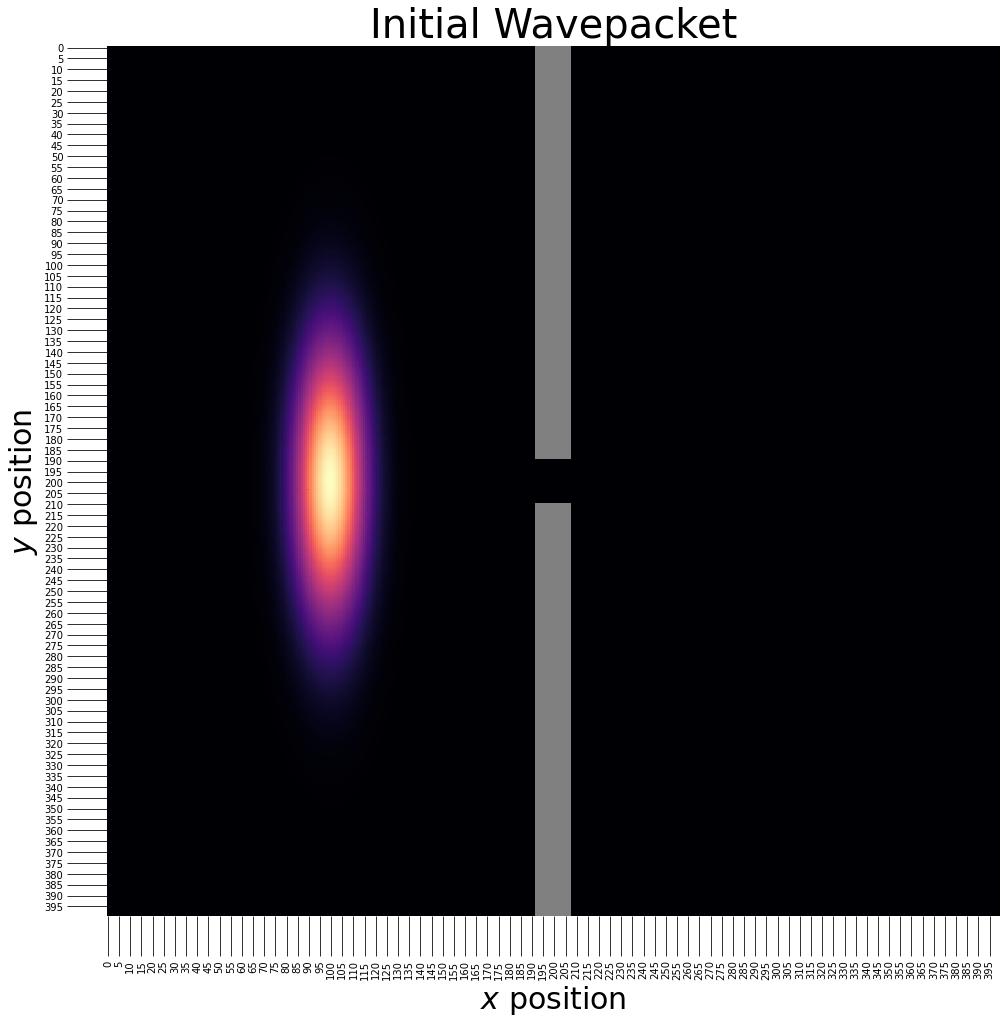

In [12]:
#plotting the heatmap
fig = plt.figure(figsize=(16,16))
sb.heatmap(data,cmap=cmap,cbar=False)
plt.xlabel(r"$x$ position",fontsize=30)
plt.ylabel(r"$y$ position",fontsize=30)
plt.tick_params(size=40)
plt.title('Initial Wavepacket',fontsize=40)
plt.savefig("initial")

# Time Dependent Schrodinger Equation

$${i\hbar \frac{{\partial  \psi \left( {x,y,t} \right)}}{{\partial  t}} =  - \frac{{{\hbar ^2}}}{{2 m}}\left( {\frac{{{\partial ^2} \psi }}{{\partial  {x^2}}} + \frac{{{\partial ^2} \psi }}{{\partial  {y^2}}}} \right) + V\left( {x,y} \right) \,\psi }$$

## Alternating Direction Implicit Method
## X-Direction Step

$$
i \hbar \frac{\psi_{i,j}^{n+1}-\psi_{i,j}^{n}}{\Delta t} = \frac{-\hbar^2}{2m}\left[\frac{\psi_{i+1,j}^{n+1}+\psi_{i-1,j}^{n+1}-2\psi_{i,j}^{n+1}}{(\Delta x)^2} + \frac{\psi_{i,j+1}^{n}+\psi_{i,j-1}^{n}-2\psi_{i,j}^{n}}{(\Delta y)^2}\right] + \left[V_{i,j}\psi_{i,j}^n+V_{i,j}\psi_{i,j}^{n+1}\right]
$$


Setting $\Delta x = \Delta y$, and $\hbar = m = 1$,

$$
\psi_{i,j}^{n+1}-\psi_{i,j}^{n} = \frac{i\Delta t}{2(\Delta x)^2}\left[\psi_{i+1,j}^{n+1}+\psi_{i-1,j}^{n+1}-2\psi_{i,j}^{n+1} + \psi_{i,j+1}^{n}+\psi_{i,j-1}^{n}-2\psi_{i,j}^{n}\right] - i\Delta t\left[V_{i,j}\psi_{i,j}^n+V_{i,j}\psi_{i,j}^{n+1}\right]
$$

Collecting terms of the same spatial indices on either side, and letting $\alpha = i\Delta t/(2\Delta x^2)$, $\beta = i\Delta t$,

$$
\psi_{i,j}^{n+1}-\alpha\left[\psi_{i+1,j}^{n+1}+\psi_{i-1,j}^{n+1}-2\psi_{i,j}^{n+1}\right]+\beta V_{i,j}\psi_{i,j}^{n+1} = \psi_{i,j}^{n}+\alpha\left[\psi_{i,j+1}^{n}+\psi_{i,j-1}^{n}-2\psi_{i,j}^{n}\right] - \beta V_{i,j}\psi_{i,j}^n
$$

$$
\psi_{i,j}^{n+1}(1+2\alpha+\beta V_{i,j})-\alpha\left[\psi_{i+1,j}^{n+1}+\psi_{i-1,j}^{n+1}\right]= \psi_{i,j}^{n}+\alpha\left[\psi_{i,j+1}^{n}+\psi_{i,j-1}^{n}-2\psi_{i,j}^{n}\right] - \beta V_{i,j}\psi_{i,j}^n
$$

Now, each side is evidently a matrix equation, of the following form. The left hand side is

$$
\begin{pmatrix}
1+2\alpha + \beta V_{0,j} & -\alpha & 0 & 0 & ... \\
-\alpha & 1+2\alpha + \beta V_{1,j} & -\alpha & 0 & ... \\
0 & -\alpha & 1+2\alpha + \beta V_{2,j} & -\alpha & ...
\end{pmatrix}\begin{pmatrix}
\psi_{0,j}^{n+1} \\
\psi_{1,j}^{n+1} \\
...
\end{pmatrix}$$


And the right hand side is

$$\begin{pmatrix}
1-2\alpha - \beta V_{i,0} & \alpha & 0 & 0 & ... \\
\alpha & 1-2\alpha - \beta V_{i,1} & \alpha & 0 & ... \\
0 & \alpha & 1-2\alpha - \beta V_{i,2} & \alpha & ...
\end{pmatrix}\begin{pmatrix}
\psi_{i,0}^{n} \\
\psi_{i,1}^{n} \\...\end{pmatrix}$$

The vectors are written in different orders for simplicity, but they can be rearranged to obtain the equation.

This is a tridiagonal matrix, which can be solved efficiently.

### Y-Direction Step

The next time step is done with alternating the $x,y$ derivatives. 




The left hand side reads

$$\begin{pmatrix}
1+2\alpha + \beta V_{i,0} & -\alpha & 0 & 0 & ... \\
-\alpha & 1+2\alpha + \beta V_{i,1} & -\alpha & 0 & ... \\
0 & -\alpha & 1+2\alpha + \beta V_{i,2} & -\alpha & ...
\end{pmatrix}\begin{pmatrix}
\psi_{i,0}^{n+2} \\
\psi_{i,1}^{n+2} \\...\end{pmatrix}$$


And the right hand side is
$$
\begin{pmatrix}
1-2\alpha - \beta V_{0,j} & \alpha & 0 & 0 & ... \\
\alpha & 1-2\alpha - \beta V_{1,j} & \alpha & 0 & ... \\
0 & \alpha & 1-2\alpha - \beta V_{2,j} & \alpha & ...
\end{pmatrix}\begin{pmatrix}
\psi_{0,j}^{n+1} \\
\psi_{1,j}^{n+1} \\
...
\end{pmatrix}$$


### Creating matrices in Python:

In [13]:
#X direction step

blocks = []
for j in range(0,int(N/dx)):
    #here, we create arrays containing the values on the diagonal
    
    #the main diagonal differs for each j
    main_diag = 1+2*alpha +beta*V[:,j]
    
    #the off diagonals are constants
    off_diag = np.ones(len(main_diag)-1)*(-alpha)
    
    #assembling the lists and offsets
    diags = [off_diag,main_diag,off_diag]
    offsets = [-1,0,1]
    
    #creating the matrix as sparse
    block = sparse.diags(diags,offsets,format='csr')
    blocks.append(block)

#the complete matrix is a block-diagonal assembly of each block
X_step_left = sparse.block_diag(blocks,format='csr')

#the same steps are repeated for the other 3 matrices, corresponding to their relative ordering
blocks = []

for i in range(0,int(N/dx)):
    main_diag = 1-2*alpha -beta*V[i,:]
    off_diag = np.ones(len(main_diag)-1)*alpha
    diags = [off_diag,main_diag,off_diag]
    aoffsets = [-1,0,1]
    block = sparse.diags(diags,offsets,format='csr')
    blocks.append(block)

X_step_right = sparse.block_diag(blocks,format='csr')

In [14]:
#Y direction step

blocks = []
for i in range(0,steps):
    main_diag = 1+2*alpha +beta*V[i,:]
    off_diag = np.ones(len(main_diag)-1)*(-alpha)
    diags = [off_diag,main_diag,off_diag]
    offsets = [-1,0,1]
    block = sparse.diags(diags,offsets,format='csr')
    blocks.append(block)

Y_step_left = sparse.block_diag(blocks,format='csr')

blocks = []

for j in range(0,steps):
    main_diag = 1-2*alpha -beta*V[:,j]
    off_diag = np.ones(len(main_diag)-1)*alpha
    diags = [off_diag,main_diag,off_diag]
    offsets = [-1,0,1]
    block = sparse.diags(diags,offsets,format='csr')
    blocks.append(block)

Y_step_right = sparse.block_diag(blocks,format='csr')

In [15]:
#this array is the re-ordering convenience array. it contains the new indices, which are used to re-order an array 
#between different steps of the ADI process
#it is used in both directions
#for steps=N, it sends
#0->0
#1->N
#2->2N
#...
#N-1->(N-1)N
#N->1
#it essentially moves an element at (AN+B) to (BN+A)
re_indices = [] 
for j in range(0,steps):
    re_indices.append(np.arange(j+0,j+steps*(steps-1)+steps,steps))
re_indices = np.array(re_indices).reshape(steps**2)

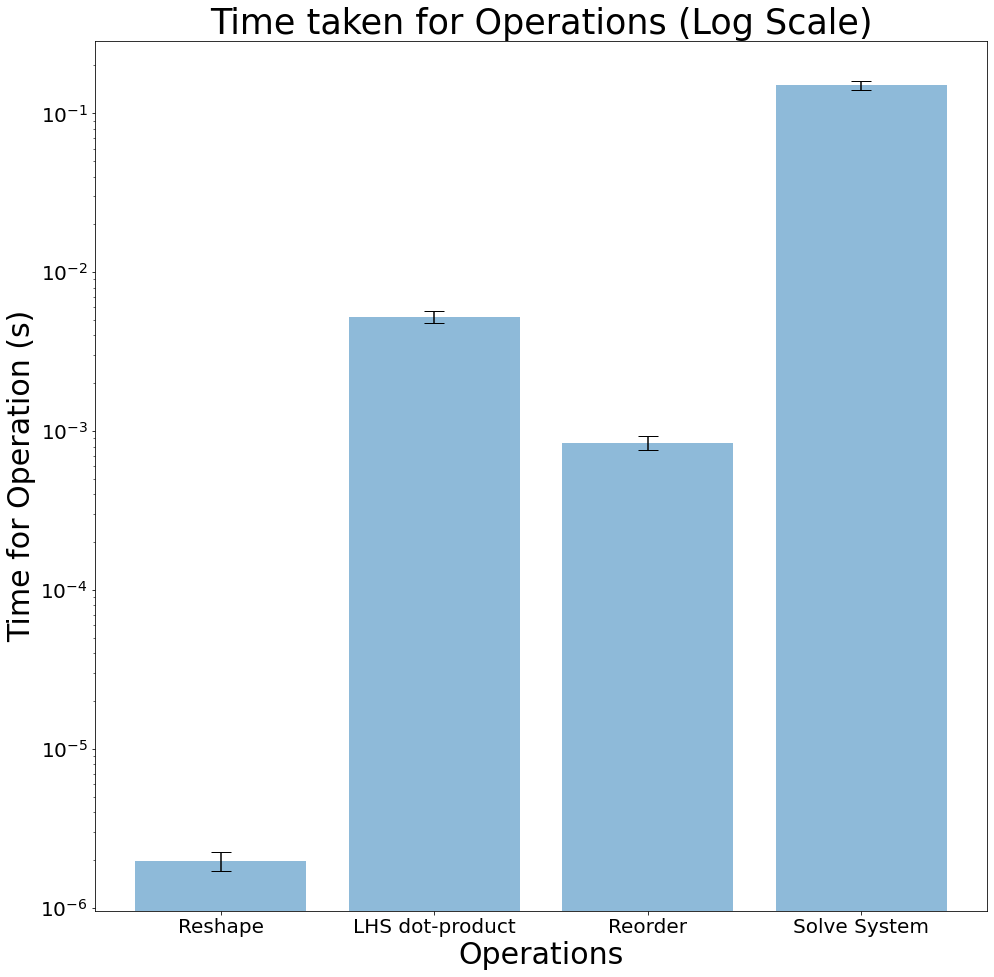

In [16]:
#these values were estimated using the %timeit magic function, and are plotted here
errors = [281e-9, 435e-6, 90.1e-6, 10.6e-3]
vals = [1.98e-6, 5.25e-3, 847e-6, 150e-3]
xpos = [1,2,3,4]
fig, ax = plt.subplots(figsize=(16,16))

ax.bar(xpos, vals, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.yscale("log")
plt.xticks(ticks=[1,2,3,4],labels=['Reshape','LHS dot-product','Reorder','Solve System'])
plt.tick_params(labelsize=20)
plt.ylabel('Time for Operation (s)',fontsize=30)
plt.xlabel('Operations',fontsize=30)
plt.title('Time taken for Operations (Log Scale)',fontsize=35)
plt.savefig('timeit')

In [17]:
#time step
wavefunction = np.zeros((steps,steps,T),dtype=np.complex128)
wavefunction[:,:,0] = initial_wavefunc
for time in tqdm(range(1,T)):
    #initial state: {i=0, j=0...N},{i=1,j=0...N}
    wf_vector = wavefunction[:,:,time-1].reshape(steps**2,order='C')
    #apply right hand side for X
    r=X_step_right.dot(wf_vector)
    #reshape for left hand side {j=0, i=0...N},...
    r_n = r[re_indices]
    #solve for wavefunction
    wf_xstep = spsolve(X_step_left,r_n)
    #apply right hand side for Y
    r2 = Y_step_right.dot(wf_xstep)
    #reshape for left hand side: {i=0, j=0...N},{i=1,j=0...N}
    r2_n = r2[re_indices]
    #solve for wavefunction
    wf_ystep = spsolve(Y_step_left,r2_n)
    #reshape back into matrix form and save
    wavefunction[:,:,time] = wf_ystep.reshape((steps,steps),order='C')

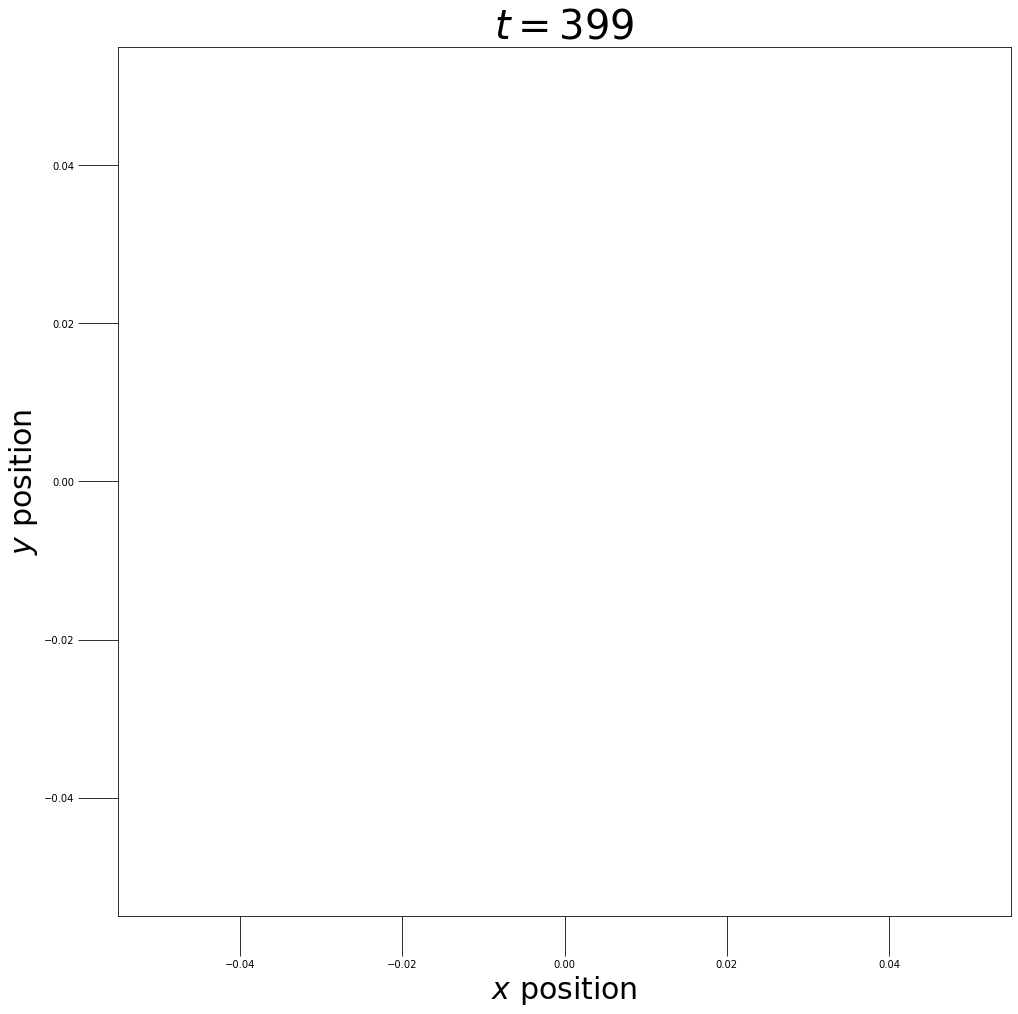

In [24]:
#setting up the animation

#setting up figure and axes properties
fig, ax = plt.subplots(figsize=(16,16))

line2d, = ax.plot([], [], lw=2)
ax.set_xlabel(r"$x$ position",fontsize=30)
ax.set_ylabel(r"$y$ position",fontsize=30)
ax.tick_params(size=40)
ax.set_title(r'$t = ' + str(i)+'$',fontsize=40)   
ax_global = ax

# initialization function 
def init():
    line2d.set_data([], [])
    
    #setting the wavefunction to be NAN at the slit wall
    data=np.absolute(wavefunction[:,:,0])**2
    data[0:s1_b,slit_x-eps:slit_x+eps]=np.nan
    data[s1_t:s2_b,slit_x-eps:slit_x+eps]=np.nan
    data[s2_t:s3_b,slit_x-eps:slit_x+eps]=np.nan
    data[s3_t:s4_b,slit_x-eps:slit_x+eps]=np.nan
    data[s4_t:s5_b,slit_x-eps:slit_x+eps]=np.nan
    data[s5_t:-1,slit_x-eps:slit_x+eps]=np.nan
    
    #heatmapping
    sb.heatmap(data,cmap=cmap,cbar=False,ax=ax_global)
    ax.set_yticks([0,50,100,150,200,250,300,350,400])
    ax.set_xticklabels([0,50,100,150,200,250,300,350,400])
    ax.set_xticks([0,50,100,150,200,250,300,350,400])
    ax.set_yticklabels([0,50,100,150,200,250,300,350,400])
    

    return (line2d,)



def animate(i):

    #setting the wavefunction to be NAN at the slit wall
    data=np.absolute(wavefunction[:,:,i])**2
    data[0:s1_b,slit_x-eps:slit_x+eps]=np.nan
    data[s1_t:s2_b,slit_x-eps:slit_x+eps]=np.nan
    data[s2_t:s3_b,slit_x-eps:slit_x+eps]=np.nan
    data[s3_t:s4_b,slit_x-eps:slit_x+eps]=np.nan
    data[s4_t:s5_b,slit_x-eps:slit_x+eps]=np.nan
    data[s5_t:-1,slit_x-eps:slit_x+eps]=np.nan
    
    

    #heatmapping
    sb.heatmap(data,cmap=cmap,cbar=False,ax=ax_global)
    
    ax.set_xlabel(r"$x$ position",fontsize=30)
    ax.set_ylabel(r"$y$ position",fontsize=30)
    ax.tick_params(labelsize=15)
    ax.set_yticks([0,50,100,150,200,250,300,350,400])
    ax.set_xticklabels([0,50,100,150,200,250,300,350,400])
    ax.set_xticks([0,50,100,150,200,250,300,350,400])
    ax.set_yticklabels([0,50,100,150,200,250,300,350,400])

    ax.set_title(r'$t = ' + str(i)+'$',fontsize=40)  
    fig.savefig('t = ' + str(i))
    
    ax.set_title('Frame: ' + str(i))  
    
    return (line2d,)

# call the animator	 

In [19]:
#producing the animation object
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=np.arange(0,250,10), interval=200, blit=True) 
#HTML(anim.to_html5_video())

In [20]:
#saving the animation to disk
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
anim.save('final anim.mp4', writer=writer)

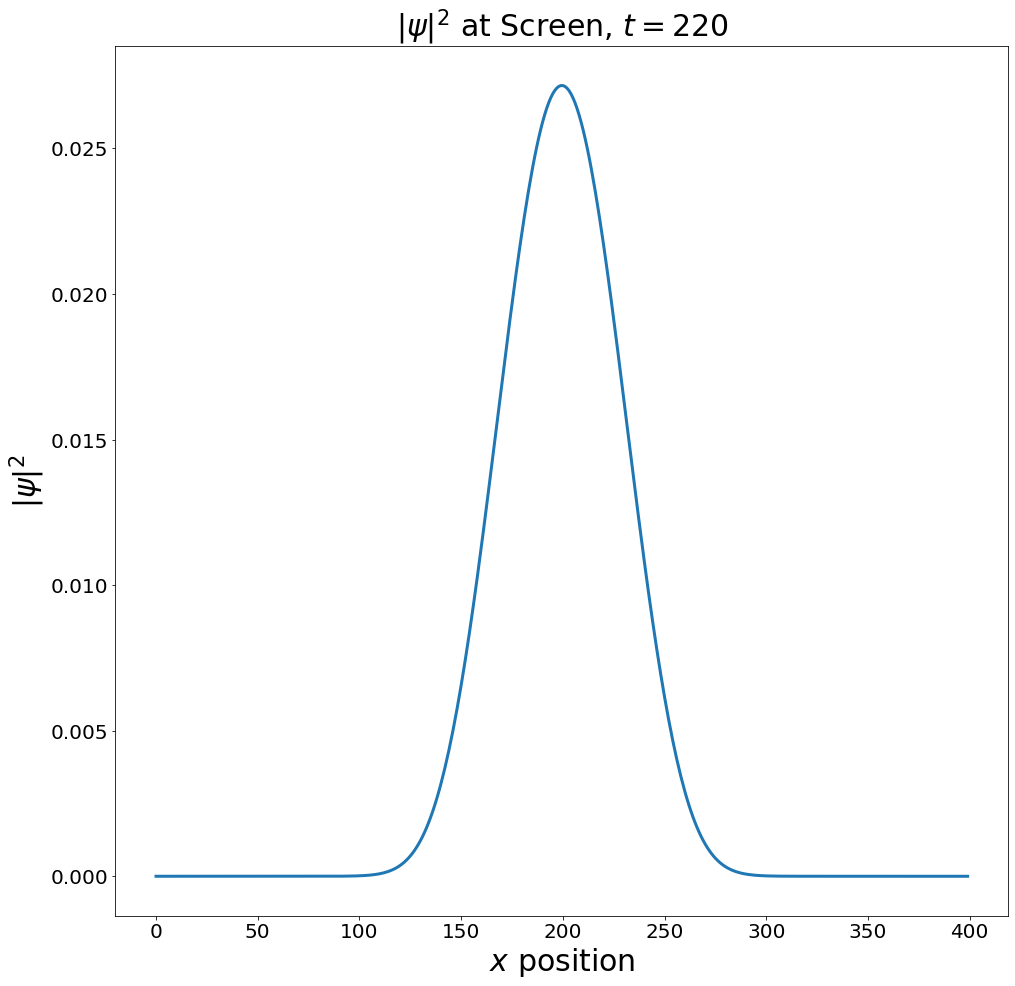

In [25]:
#convenience function to plot the x-slice of the prob. density
def f(x,t):
    fig=plt.figure(figsize=(16,16))
    d=np.absolute(wavefunction[:,x,t])**2
    d=d/np.trapz(d,dx=dx)
    p=plt.plot(d,lw=3)
    plt.title(r"$|\psi|^2$ at Screen, $t = "+str(t)+"$",fontsize=30)
    plt.ylabel(r"$|\psi|^2$",fontsize=30)
    plt.xlabel(r"$x$ position",fontsize=30)
    plt.tick_params(labelsize=20)
    
    #plt.savefig('screen x='+str(x)+', t='+str(t)+'.png')
    
    return p
                   
for t in [220]:
    x=300
    f(x,t)

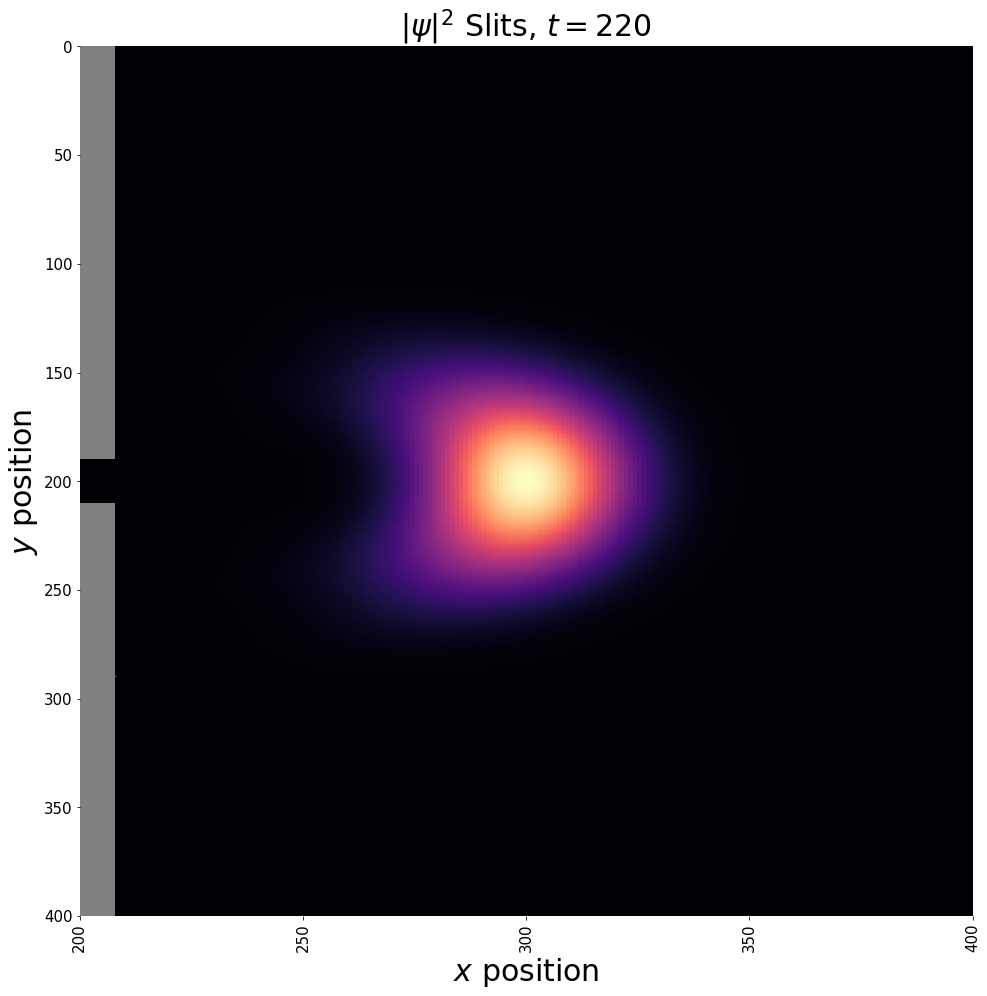

In [27]:
#convenience function to plot the 2d heatmap of the prob. dens, after the wall, at some time t 
#this zooming in allows us to see the slit interference pattern clearly
t=220

plt.figure(figsize=(16,16))
data=np.absolute(wavefunction[:,:,t])**2
data[0:s1_b,slit_x-eps:slit_x+eps]=np.nan
data[s1_t:,slit_x-eps:slit_x+eps]=np.nan
#data[s2_t:-1,slit_x-eps:slit_x+eps]=np.nan
data = data[:,200:]
sb.heatmap(data,cmap=cmap,cbar=False)
plt.title(r"$|\psi|^2$ Slits, $t = "+str(t)+"$",fontsize=30)
plt.ylabel(r"$y$ position",fontsize=30)
plt.xlabel(r"$x$ position",fontsize=30)
plt.tick_params(labelsize=15)
plt.yticks(ticks=[0,50,100,150,200,250,300,350,400],labels=[0,50,100,150,200,250,300,350,400])
plt.xticks(ticks=[0,50,100,150,200],labels=[200,250,300,350,400])
plt.savefig('2d after slits')